# Programming Assignment-2
The goal of this assingment is to allow you to practice several the following things in Python:
1. Perfoming typical data processing (or preprocessing if you prefer). This includes all the typical data wraning such as creating news variables, combining several datasets and more 
2. Running explolatory data analysis including basic plotting of variables 
3. Perfoming basic inferential statisticals using statsmodels and scipy to run hypythesis testing and build simple statistial or econometric models.

## Datasets 
For this assignment, you will use the following datasets:
### Rwanda Health Indicators
The Excel file was generated by combining multiple CSV files, each containing data on different health indicators for Rwanda, So that each sheet in the file represent one such indicator. See below some of the input files which were used:
- `access-to-health-care_subnational_rwa`
- `child-mortality-rates_subnational_rwa`
- `dhs-mobile_subnational_rwa`

You can download the dataset from [here](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true).
### Nights lights Data
- Please download it [here](https://drive.google.com/file/d/1f_4fiqxIejly0YmC088s9bxOfrABv9Sz/view?usp=sharing) and check the documentation in the cells below. 

### Popupation Dataset
- Please download it [here](https://drive.google.com/file/d/1FWEFGdN-xDuFH1jmt0hr4F8Xc3Y5XzvB/view?usp=share_link) and check the documentation and metadata in the class notebooks.


## Submission Guidelines 
- Please guidelines and complete all steps in the [GitHub Workflow](https://dmatekenya.github.io/AIMS-DSCBI/course-requirements/github-workflow.html)
- Once you have completed your assignment, push chanegs to your repository.
- Send a link (copy from within GitHub) to your notebook to the tutors/teaching assistants


# Import Required Packages

In [1]:
from pathlib import Path
import pandas as pd

# Setup Input Folders

As usual, it is good practice to set up input folders using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package. In this section, make sure to define the folders where your data is stored on your machine.

I find it helpful to set up the working directory and input data folders right at the start of the notebook. To keep things organized, I use the naming convention: `FILE_{NAME}` for files and `DIR_{NAME}` for folders. We use capital letters because these are global variables that will be referenced throughout the notebook.

We'll be using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) library, which offers several advantages over traditional string-based path handling:

- **Cross-platform compatibility** - automatically handles path separators (`/` vs `\`) across different operating systems
- **Object-oriented approach** - paths are objects with useful methods rather than strings
- **Intuitive syntax** - use `/` operator to join paths naturally: `parent_dir / "subfolder" / "file.txt"`
- **Built-in path operations** - methods like `.exists()`, `.is_file()`, `.parent`, `.stem`, and `.suffix`
- **Safer path manipulation** - reduces errors from manual string concatenation and splitting

This is the recommended approach for managing file paths in modern Python development.


In [2]:
# Uncomment the following lines and add your code to define the directories and files
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_EXCEL = DIR_DATA/"RW-Health-Data.xlsx"

# Population by enumeration area (EA) for Malawi
# FILE_POP_MW = ADD YOUR CODE


# Part 1: Processing Excel Files
The primary goal is to preprocess an [Excel file](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true) with multiple sheets into a unified CSV dataset that consolidates multiple indicators. Having all indicators in a single file at the same analytical unit (national, subnational) is more efficient than managing separate files and enables easier cross-indicator analysis.

## Task 1: Generate National-Level Summaries

For each indicator, compute a single national-level value using appropriate aggregation functions such as **mean**, **sum** or **count**. For this one, all available indicators can be summarized at national level, so we will have a CSV file with one row and 

### Expected Output Structure
1. **DataFrame display** in Jupyter Notebook
2. **CSV file** with columns:
- `indicator_name`: Name of the indicator
- `aggregated_value`: Computed national value
- `indicator_year`: Survey year or something similar
- `survey_name`: Name of the survey where information is coming from
- `aggregation_method`: Statistical method used (optional)

## Task 2: Subnational-Level Indicator Dataset

Create a merged dataset for indicators with subnational data (ADM2/ADM3 levels), ensuring spatial alignment and consistent administrative boundaries.

### Expected Output Structure
   - `indicator_name`: Name of the indicator
   - `aggregated_value`: Computed national value
   - `indicator_year`: Survey year or something similar
   - `survey_name`: Name of the survey where information is coming from
   - `aggregation_method`: Statistical method used (optional)

This structure enables both single-indicator and multi-indicator analysis at the subnational level.

QUESTION 1 -  Task 1: Generate National-Level Summaries

In [12]:
xls = pd.ExcelFile(FILE_EXCEL)
sheet_names = xls.sheet_names

# Define aggregation rules per indicator if needed
# (default is mean if indicator is not listed)
aggregation_rules = {
    # Example:
    # 'Population': 'sum',
    # 'Number of facilities': 'count'
}

results = []

for sheet in sheet_names:
    df = pd.read_excel(FILE_EXCEL, sheet_name=sheet)

    # Drop metadata row if present
    if '#indicator+value+num' in str(df.iloc[0].get('Value', '')):
        df = df.iloc[1:].copy()

    # Convert Value to numeric and drop invalid rows
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df.dropna(subset=['Value', 'Indicator'])

    indicators = df['Indicator'].unique()

    for ind in indicators:
        sub_df = df[df['Indicator'] == ind]

        # Choose aggregation method
        agg_method = aggregation_rules.get(ind, 'mean')
        if agg_method == 'mean':
            value = sub_df['Value'].mean()
        elif agg_method == 'sum':
            value = sub_df['Value'].sum()
        elif agg_method == 'count':
            value = sub_df['Value'].count()
        else:
            value = sub_df['Value'].mean()  # fallback

        year = sub_df['SurveyYear'].mode().iloc[0] if not sub_df['SurveyYear'].isna().all() else None
        survey_id = sub_df['SurveyId'].mode().iloc[0] if not sub_df['SurveyId'].isna().all() else None
        survey_type = sub_df['SurveyType'].mode().iloc[0] if 'SurveyType' in sub_df.columns and not sub_df['SurveyType'].isna().all() else None

        results.append({
            'indicator_name': ind,
            'aggregated_value': value,
            'indicator_year': year,
            'survey_name': survey_id,
            'survey_type': survey_type,
            'aggregation_method': agg_method
        })

# Combine results into a DataFrame
custom_national_summary = pd.DataFrame(results)

# Save to CSV file
output_file = "national_summary_file.csv"
custom_national_summary.to_csv(output_file, index=False)

# Display the DataFrame (Jupyter Notebook)
custom_national_summary.head()

,indicator_name,aggregated_value,indicator_year,survey_name,survey_type,aggregation_method
0,Total fertility rate 15-49,5.269697,2000,RW2000DHS,DHS,mean
1,General fertility rate,168.727273,2000,RW2000DHS,DHS,mean
2,Median age at first birth for women age 25-49,22.103571,2000,RW2000DHS,DHS,mean
3,Women who want no more children,40.468000,2000,RW2000DHS,DHS,mean
4,Mean ideal number of children for all women,4.141071,2000,RW2000DHS,DHS,mean


QUESTION 1 - Task 2: Subnational-Level Indicator Dataset

In [ ]:
from pathlib import Path

import pandas as pd
import re

# -----------------------------------
# 1. Load workbook and identify sheets with subnational data
# -----------------------------------

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_EXCEL = DIR_DATA/"RW-Health-Data.xlsx"

# Load the Excel file

xls = pd.ExcelFile(FILE_EXCEL)
sheet_names = xls.sheet_names

# Remove the first row (metadata)
df_modified = df.iloc[1:]

# Save the modified data to a new CSV file
df_modified.to_csv('data_without_metadata.csv', index=False)

# Sheets considered ADM2/ADM3 = anything containing the phrase "subnation" (customize if needed)
subnational_sheets = [s for s in xls.sheet_names if re.search(r"subnation", s, re.IGNORECASE)]

# -----------------------------------
# 2. Function to load & clean each sub-national sheet
# -----------------------------------
def load_and_clean(sheet_name):
    df = pd.read_excel(xls, sheet_name=sheet_name)

    # Standardize column names (lowercase, no spaces)
    df.columns = df.columns.str.strip().str.lower().str.replace(r"\s+", "_", regex=True)

    # Ensure we have a 'location' column or equivalent (ADM2/ADM3 identifier)
    # Some sheets may label it differently – handle cases here:
    possible_loc_cols = ['location', 'characteristiclabel']
    loc_col = None
    for col in possible_loc_cols:
        if col in df.columns:
            loc_col = col
            break

    if loc_col is None:
        raise ValueError(f"Location column not found in {sheet_name}")

    # Clean the location names (trim, lowercase)
    df[loc_col] = df[loc_col].astype(str).str.strip().str.lower()

    # Keep only needed columns
    keep = [loc_col, "indicator", "value"]
    df = df[[c for c in keep if c in df.columns]]

    # Add a sheet identifier to track survey name
    df["survey_name"] = sheet_name

    return df.rename(columns={loc_col: "adm_location"})

# -----------------------------------
# 3. Load, clean, and append all ADM2/ADM3 datasets
# -----------------------------------
frames = []
possible_location_cols = ['location', 'characteristiclabel']
for s in subnational_sheets: 
    f = load_and_clean(s)
    frames.append(f)
    

def load_and_clean(sheet_name):
    df = xls.parse(sheet_name)

    # remove metadata row if needed
    # df = df.iloc[1:].reset_index(drop=True)

    # detect location column (flexible check)
    loc_col = None
    for c in df.columns:
        if c.strip().lower() in possible_location_cols:
            loc_col = c
            break

    if loc_col is None:
        raise ValueError(f"Location column not found in {sheet_name}")

    # clean & normalize
    df[loc_col] = df[loc_col].astype(str).str.strip().str.lower()
    df["indicator_name"] = sheet_name
    df["survey_name"] = sheet_name

    return df.rename(columns={loc_col: "adm_location"})
f = load_and_clean(s)
frames.append(f)

merged_df = pd.concat(frames, ignore_index=True)


# -----------------------------------
# 4. Preview and save
# -----------------------------------
print(merged_df.head(10))
merged_df.to_csv("merged_subnational_indicators.csv", index=False)
print("Merged dataset saved to merged_subnational_indicators.csv")


          adm_location                   indicator                 value  \
0            #loc+name             #indicator+name  #indicator+value+num   
1      butare/gitarama  Total fertility rate 15-49                   5.2   
2               butare  Total fertility rate 15-49                   4.8   
3             gitarama  Total fertility rate 15-49                   5.5   
4       byumba/kibungo  Total fertility rate 15-49                   6.4   
5               byumba  Total fertility rate 15-49                   6.2   
6              kibungo  Total fertility rate 15-49                   6.5   
7  cyangugu/ginkongoro  Total fertility rate 15-49                   6.5   
8             cyangugu  Total fertility rate 15-49                   7.5   
9            gikongoro  Total fertility rate 15-49                   5.7   

                  survey_name ISO3 DataId Indicator Value Precision  \
0  dhs-mobile_subnational_rwa  NaN    NaN       NaN   NaN       NaN   
1  dhs-mobile_subnati

## Introduction to Nightlights Dataset

## What is Nightlight Data?

Nightlight data is satellite imagery capturing artificial light emissions from Earth's surface during nighttime. Satellites like VIIRS collect this data regularly, providing an **objective, real-time measure of human economic activity and development**.

### Raw Data: Radiance Measurements
The fundamental measurement in nightlight data is **radiance** - the amount of light energy detected by satellite sensors, measured in **nanowatts per square centimeter per steradian (nW/cm²/sr)**. Each pixel in satellite imagery contains a radiance value representing the light intensity from that specific location on Earth's surface.

### Annual Composite Generation
This dataset was created from **annual composite images** using VIIRS nightlight files for Rwanda. Annual composites are generated by:

- **Aggregating daily/monthly observations** throughout each year (2015, 2020, 2024)
- **Filtering out temporary light sources** (fires, lightning, aurora)
- **Removing cloud-affected observations** to ensure clear measurements
- **Averaging or taking median values** to create stable, representative annual measurements
- **Masking techniques** to exclude areas with unreliable data

The files used include both **average composites** (`average_masked`) and **median composites** (`median_masked`), with **cloud-free versions** (`vcmslcfg`) preferred over cloud-inclusive versions (`vcmcfg`) for more accurate measurements.

### Why Use Nightlight Data?

- **Consistent global coverage** - Available everywhere, regardless of local data quality
- **Real-time updates** - More current than traditional economic statistics
- **Objective measurement** - Not subject to reporting biases
- **High resolution** - Captures local development patterns
- **Proxy for development** - Light intensity correlates with economic activity, infrastructure, and quality of life

## Dataset Overview 

- **6,507 observations** across Rwanda's administrative cells
- **Three time periods**: 2015, 2020, 2024
- **Cell-level data** - Rwanda's smallest administrative units
- Allows temporal analysis of development trends

---

## Variable Definitions

### Administrative Identifiers
- **`cell_id`** - Unique identifier for linking with other datasets
- **`province_name`** - Province (5 total in Rwanda)
- **`district_name`** - District (30 total in Rwanda) 
- **`sector_name`** - Administrative level between district and cell
- **`cell_name`** - Specific cell name

### Core Nightlight Measurements

#### `total_nightlight`
- **Sum of all radiance values** within cell boundaries
- **Key indicator** of overall economic activity/development
- Higher values = more total development

#### `mean_nightlight` 
- **Average radiance** per pixel
- Indicates development intensity regardless of cell size
- Useful for comparing cells of different areas

#### `median_nightlight`
- **Middle radiance value** of all pixels (less sensitive to outliers)
- Better represents typical lighting in unevenly developed areas

#### `max_nightlight`
- **Highest radiance** within cell
- Indicates major infrastructure (hospitals, commercial centers)

#### `min_nightlight` & `std_nightlight`
- Minimum radiance and standard deviation
- High std = uneven development within cell

### Spatial Coverage Indicators

#### `pixel_count`
- **Total pixels** in cell (indicates geographic size)
- Used to normalize other measurements

#### `lit_pixel_count`
- **Number of pixels with detectable light** (radiance > 0)
- Shows spatial extent of development

#### `lit_pixel_percentage`
- **Percentage of cell area with lighting**
- Formula: `(lit_pixel_count ÷ pixel_count) × 100`
- **0% = completely dark, 100% = fully developed**

#### `year`
- Time period: 2015, 2020, or 2024

QUESTION 2  - PART A: Variable Generation and Data Integration

In [37]:

from pathlib import Path
import pandas as pd

# Load the CSV

DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_RWA_CELL = DIR_DATA/"rwa-cell-pop.csv"
df = pd.read_csv(FILE_RWA_CELL)

# -------------------------------------------
# 1. Working-age population
# -------------------------------------------
df['working_age_population'] = (
    df['general_2020'] 
    - df['children_under_five_2020'] 
    - df['elderly_60_plus_2020']
)

# -------------------------------------------
# 2. Dependency ratio
# -------------------------------------------
df['dependency_ratio'] = (
    (df['children_under_five_2020'] + df['elderly_60_plus_2020']) 
    / df['working_age_population']
) * 100

# -------------------------------------------
# 3. People per building
# -------------------------------------------
df['people_per_building'] = df['general_2020'] / df['building_count']

# -------------------------------------------
# 4. Infrastructure index (example formula)
#    (you can refine the formula as needed)
# -------------------------------------------
# normalize people_per_building between 0 and 1
ppb_norm = (
    (df['people_per_building'] - df['people_per_building'].min()) /
    (df['people_per_building'].max() - df['people_per_building'].min())
)

# example index: combine normalized ppb & dependency_ratio
df['infrastructure_index'] = (
    0.6 * ppb_norm + 0.4 * (df['dependency_ratio'] / 100)
)

# Preview
print(df.head())

# Save new file
df.to_csv("rwa-cell-pop_with_derived_vars.csv", index=False)
print("Saved to rwa-cell-pop_with_derived_vars.csv")


         cell_id province_name district_name sector_name cell_name  \
0  RWA.1.1.1.1_1  Amajyaruguru        Burera      Bungwe    Bungwe   
1  RWA.1.1.1.2_1  Amajyaruguru        Burera      Bungwe  Bushenya   
2  RWA.1.1.1.3_1  Amajyaruguru        Burera      Bungwe  Mudugari   
3  RWA.1.1.1.4_1  Amajyaruguru        Burera      Bungwe     Tumba   
4  RWA.1.1.2.1_1  Amajyaruguru        Burera      Butaro   Gatsibo   

   elderly_60_plus_2020  general_2020  children_under_five_2020  \
0            241.693282   3855.623385                495.422606   
1            229.611624   3669.128833                470.655098   
2            109.718616   1756.630395                225.188715   
3            318.065743   5174.177333                666.434701   
4            335.976866   6046.478580                833.994018   

   youth_15_24_2020     men_2020   women_2020  building_count  \
0        758.093936  1850.711053  2004.912332          1435.0   
1        720.896415  1761.457437  1907.671396 

QUESTION 2 - PART A: Nightlight Dataset Variables

In [38]:
import pandas as pd
from pathlib import Path

# Paths
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_NIGHT_RW = DIR_DATA / "cell-ntl-2015-2020-2024.csv"
OUTPUT_FILE = DIR_DATA / "rw-cell-nightlight_file.csv"

# Load data
df = pd.read_csv(FILE_NIGHT_RW)

# Keep only 2015 & 2024
df_filtered = df[df['year'].isin([2015, 2024])].copy()

# Pivot so each cell_id has 2015 & 2024 on a single row
pivot = df_filtered.pivot(index='cell_id', columns='year', values=['total_nightlight','mean_nightlight','lit_pixel_count','pixel_count'])

# Drop cells missing either 2015 or 2024
pivot = pivot.dropna(subset=[('total_nightlight',2015), ('total_nightlight',2024)])

# Compute indicators
out = pd.DataFrame(index=pivot.index)
out['nightlight_change_2015_2024'] = ( (pivot[('total_nightlight',2024)] - pivot[('total_nightlight',2015)]) / pivot[('total_nightlight',2015)] ) * 100
out['mean_nightlight_change_2015_2024'] = ( (pivot[('mean_nightlight',2024)] - pivot[('mean_nightlight',2015)]) / pivot[('mean_nightlight',2015)]) * 100
out['lit_pixel_percentage'] = ( pivot[('lit_pixel_count',2024)] / pivot[('pixel_count',2024)] ) * 100

# Reset index so cell_id is a column
out = out.reset_index()

# Display
out.head()


,cell_id,nightlight_change_2015_2024,mean_nightlight_change_2015_2024,lit_pixel_percentage
0,RWA.1.1.1.1_1,510.862720,510.862733,37.142857
1,RWA.1.1.1.2_1,601.012355,601.012330,42.857143
2,RWA.1.1.1.3_1,599.043610,599.043614,43.333333
3,RWA.1.1.1.4_1,534.552323,534.552310,43.434343
4,RWA.1.1.10.1_1,539.337363,539.337358,46.000000


Methodology for the Infrastructure Pressure Index Summary

A composite indicator called the infrastructure_index is used to evaluate the strain on essential services and infrastructure at the subnational level. It incorporates built-environment and demographic factors to show how well the current infrastructure satisfies the needs of the populace.

-Fundamental Logic:

When there are more people living in each unit of infrastructure and/or a larger percentage of dependents (elderly and young children) who require more on services, infrastructure demand tends to increase.
The index combines in order to capture this idea:
The number of people serviced per building is a measure of crowding.
The dependency ratio is a measure of demographic burden.
(As new variables become available, they can be included to increase index sensitivity; they include road density, school or health facility counts, and access to water sites.)

Summary
A composite indicator called the infrastructure_index is used to evaluate the strain on essential services and infrastructure at the subnational level. 

*people_per_building: Higher values = more people sharing a single building → potential overcrowding

*working_age_population: Population theoretically able to work/support dependents

*dependency_ratio: Higher values = more non-working dependents per working-age adult



QUESTION 2 PART B: Exploratory Data Analysis

QUESTION 2 PART B- Exploratory Analysis: Nightlight Trend Analysis

District Ranking: Report the top 5 districts with the highest nightlight growth (2015-2024) and bottom 5 districts with the most decline or lowest growth. 

Lit Pixel Analysis: Compare these districts using lit_pixel_percentage changes to understand whether growth represents intensification or spatial expansion.

Create visualizations showing nightlight trends for these extreme districts.

Top 5 districts (highest nightlight growth):
      district_name  ntl_growth  lit_pixel_change
0  Unknown_District    0.381186          0.044569

Bottom 5 districts (lowest/negative growth):
      district_name  ntl_growth  lit_pixel_change
0  Unknown_District    0.381186          0.044569


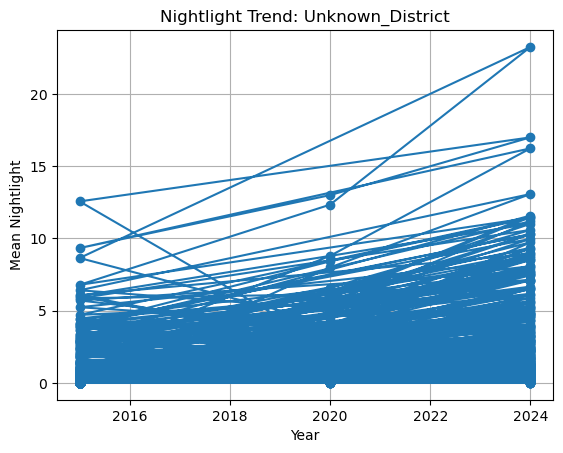

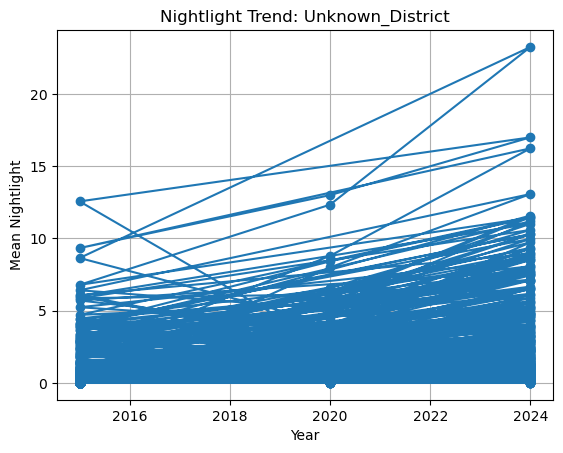

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load long-format dataset
df = pd.read_csv("cell-ntl-2015-2020-2024.csv")

# Pivot to wide format for growth calculation
df_wide = df.pivot_table(
    index='district_name',
    columns='year',
    values=['mean_nightlight', 'lit_pixel_percentage']
).reset_index()

# Rename columns for clarity
df_wide.columns = ['district_name',
                   'lit_pixel_pct_2015', 'lit_pixel_pct_2020', 'lit_pixel_pct_2024',
                   'mean_ntl_2015', 'mean_ntl_2020', 'mean_ntl_2024']

# Calculate growth & change
df_wide['ntl_growth'] = df_wide['mean_ntl_2024'] - df_wide['mean_ntl_2015']
df_wide['lit_pixel_change'] = df_wide['lit_pixel_pct_2024'] - df_wide['lit_pixel_pct_2015']

# Rank
df_sorted = df_wide.sort_values('ntl_growth', ascending=False)
top5 = df_sorted.head(5)
bottom5 = df_sorted.tail(5)

print("Top 5 districts (highest nightlight growth):")
print(top5[['district_name','ntl_growth','lit_pixel_change']])

print("\nBottom 5 districts (lowest/negative growth):")
print(bottom5[['district_name','ntl_growth','lit_pixel_change']])

# ----------------------------------------------
# Plot nightlight trends for extreme districts
# ----------------------------------------------
extreme_districts = list(top5['district_name']) + list(bottom5['district_name'])
df_trend = df[df['district_name'].isin(extreme_districts)]

for dist in extreme_districts:
    sub = df_trend[df_trend['district_name'] == dist]
    plt.figure()
    plt.plot(sub['year'], sub['mean_nightlight'], marker='o')
    plt.title(f"Nightlight Trend: {dist}")
    plt.ylabel("Mean Nightlight")
    plt.xlabel("Year")
    plt.grid(True)

plt.show()


# Part-2: Demographic and Nightlights Data

## Part A: Varible Generation and Data Integration

### Population Dataset Variables (`rwa-cell-pop.csv`):
Create the following derived variables:
- **`dependency_ratio`** - `(children_under_five_2020 + elderly_60_plus_2020) / working_age_population * 100`
- **`people_per_building`** - `general_2020 / building_count`
- **`working_age_population`** - `general_2020 - children_under_five_2020 - elderly_60_plus_2020`
- **`infrastructure_index`** - Your own formula that incorporates `people_per_building` and other relevant variables to measure infrastructure adequacy. Document and justify your `infrastructure_index` methodology, explaining how `people_per_building` and other variables contribute to measuring infrastructure pressure.

### Nightlight Dataset Variables (`cell-ntl-2015-2020-2024.csv`):
Create the following temporal and development indicators:
- **`nightlight_change_2015_2024`** - Percentage change in total nightlight from 2015 to 2024
- **`mean_nightlight_change_2015_2024`** - Percentage change in mean nightlight from 2015 to 2024
- **`lit_pixel_percentage`** - Use existing or calculate: `(lit_pixel_count / pixel_count) * 100`

### Data Integration:
Merge the datasets using the appropriate column. 

## Part B: Exploratory Data Analysis

### Correlation Analysis:
1. **Correlation Heatmap**: Create a heatmap showing correlations between 10 key variables (mix of demographic, infrastructure, and nightlight variables). 
2. **Report the top 3 variable pairs** with the highest correlations and interpret their relationships.
3. **Identify unexpected correlations** and discuss potential explanations.

### Nightlight Trend Analysis:
1. **District Ranking**: Report the **top 5 districts** with the highest nightlight growth (2015-2024) and **bottom 5 districts** with the most decline or lowest growth.
2. **Lit Pixel Analysis**: Compare these districts using `lit_pixel_percentage` changes to understand whether growth represents intensification or spatial expansion.
3. **Create visualizations** showing nightlight trends for these extreme districts.

## Part C: Modeling

### Multivariate Linear Regression:
1. **Model Development**: Build a multivariate linear regression model predicting **population density** using both demographic and nightlight variables as predictors. Explore as many variables as possible at the beginning.
2. **Variable Selection**: Test different combinations of variables and report the **top 3 most predictive variables** of population density.
3. **Model Evaluation**: Report R-squared, coefficients, and statistical significance. Interpret what these results tell us about population-infrastructure relationships.



## Notes and Other Requirements
Please follow the genral guidelines below when preparing your analysis..

### Statistical Analysis:
- Properly handle missing data and outliers
- Use appropriate statistical tests and report p-values
- Calculate and interpret correlation coefficients
- Validate regression assumptions (normality, homoscedasticity)

### Data Management:
- Document all data cleaning and aggregation steps using markdown 
- Ensure consistent district naming across datasets

### Visualization Standards:
- Create clear, publication-quality heatmaps with appropriate color scales
- Design effective time series plots for nightlight trends
- Include proper axis labels, titles, and legends
- Use consistent formatting across all visualizations

### Reporting Requirements:
- Clearly state the top 3 most predictive variables with statistical justification
- Provide ranked lists for nightlight growth districts with supporting metrics
- Include model performance statistics and interpretation
- Document all methodological choices and assumptions